# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [146]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write
import scipy

## Functions

In [147]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [148]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [149]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [150]:
play = False
if play :
    play_sound(sound) 

In [151]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

print(Fs)

48000


In [152]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

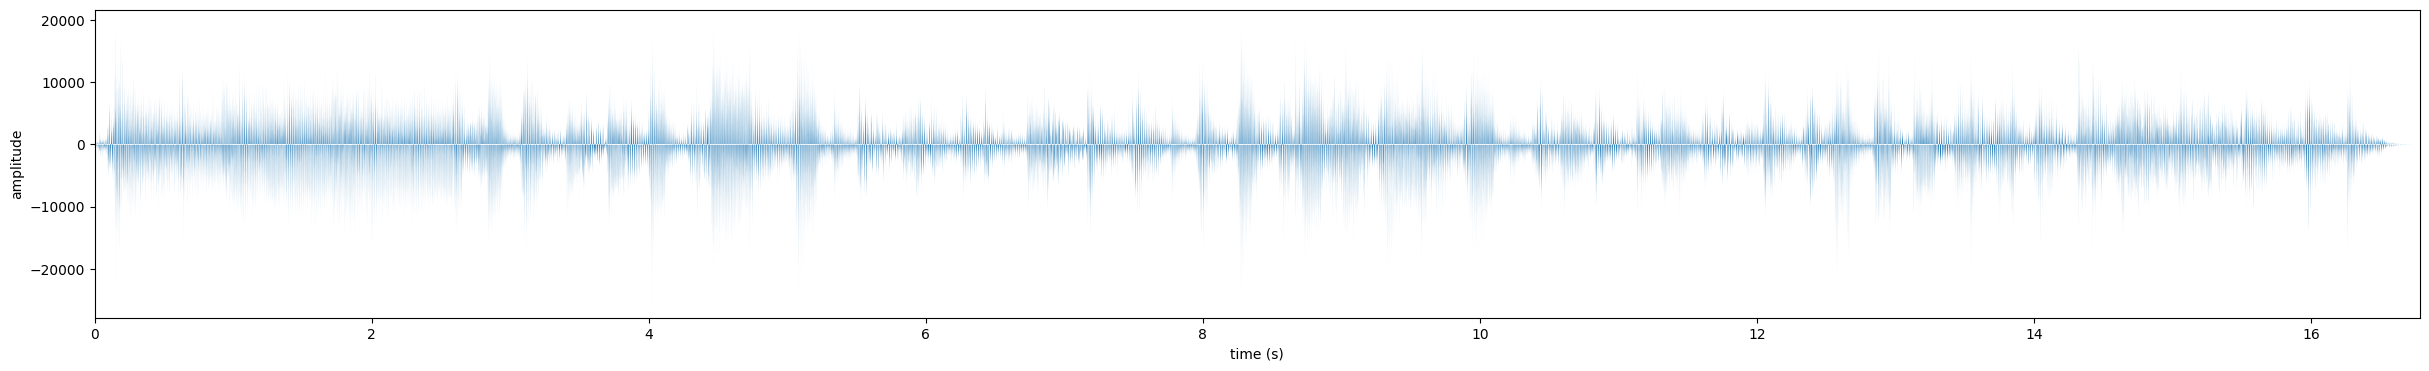

In [153]:
plot_sound(x, times)

## Conversion de fréquence d'échantillonnage

Question 1 :

On  cherche à convertir la fréquence d'échantillonnage d'un signal de 48 kHz vers 32kHz. Le filtre devra couper les fréquences supérieures à 16 kHz pour respecter le critère de Shannon et éviter le repliement du spectre. Le filtrage étant réalisé après le suréchantillonnage, la fréquence du signal à filtrer est de 96kHz. La fréquence de coupure normalisée est donc $\frac{16}{96}=\frac{1}{6}$.

$$
H(e^{2i\pi\nu}) = \left\{
\begin{array}{ll}
    2&Si~\nu\in[-\frac{1}{6},\frac{1}{6}]\\
    0&Sinon
\end{array}
\right.
$$
Le schéma de conversion est alors le suivant :
<p align="center">
<img src="conv_freq_1.jpg">
</p>

In [154]:
def plot_response(fs, w, h, title):
    "Utility function to plot response functions - Source Scipy: Documentation"
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax.set_xlim(0, 0.5*fs)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)

Question 2 :

On génère ensuite ce filtre à l'aide de la méthode de Rémez. Le filtre n'étant pas idéal, on doit relâcher quelques contraintes sur le filtre. On veut cependant une atténuation de 50 dB par rapport à la bande passante et une atténuation maximale à 16kHz. On choisit donc l'ordre du filtre et la largeur de la bande de transition en fonction de ces contraintes.

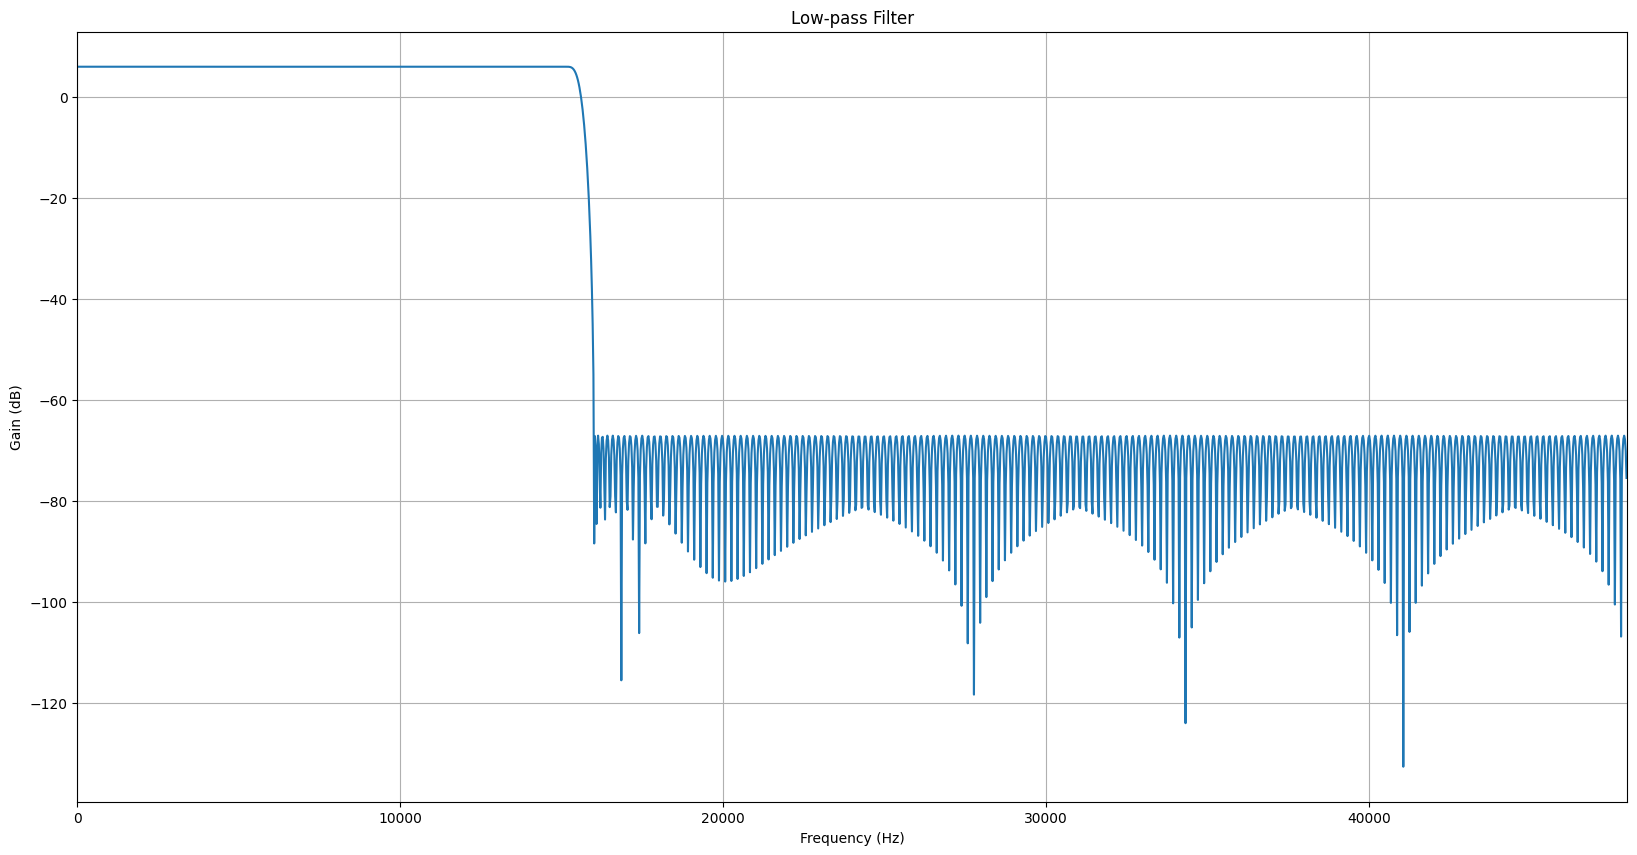

In [155]:
L = 2
M = 3

fs = L*Fs
cutoff = 16000.0    # Desired cutoff frequency, Hz
trans_width = 800  # Width of transition from pass band to stop band, Hz
numtaps = 500      # Size of the FIR filter.
taps = scipy.signal.remez(numtaps, [0, cutoff - trans_width, cutoff, 0.5*fs], [L, 0], Hz=fs)
w, h = scipy.signal.freqz(taps, [1], worN=2000)
plot_response(fs, w, h, "Low-pass Filter")

Question 3 :

Enfin, on applique la conversion de fréquence d'échantillonnage au signal de départ.

73.6 ms ± 750 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


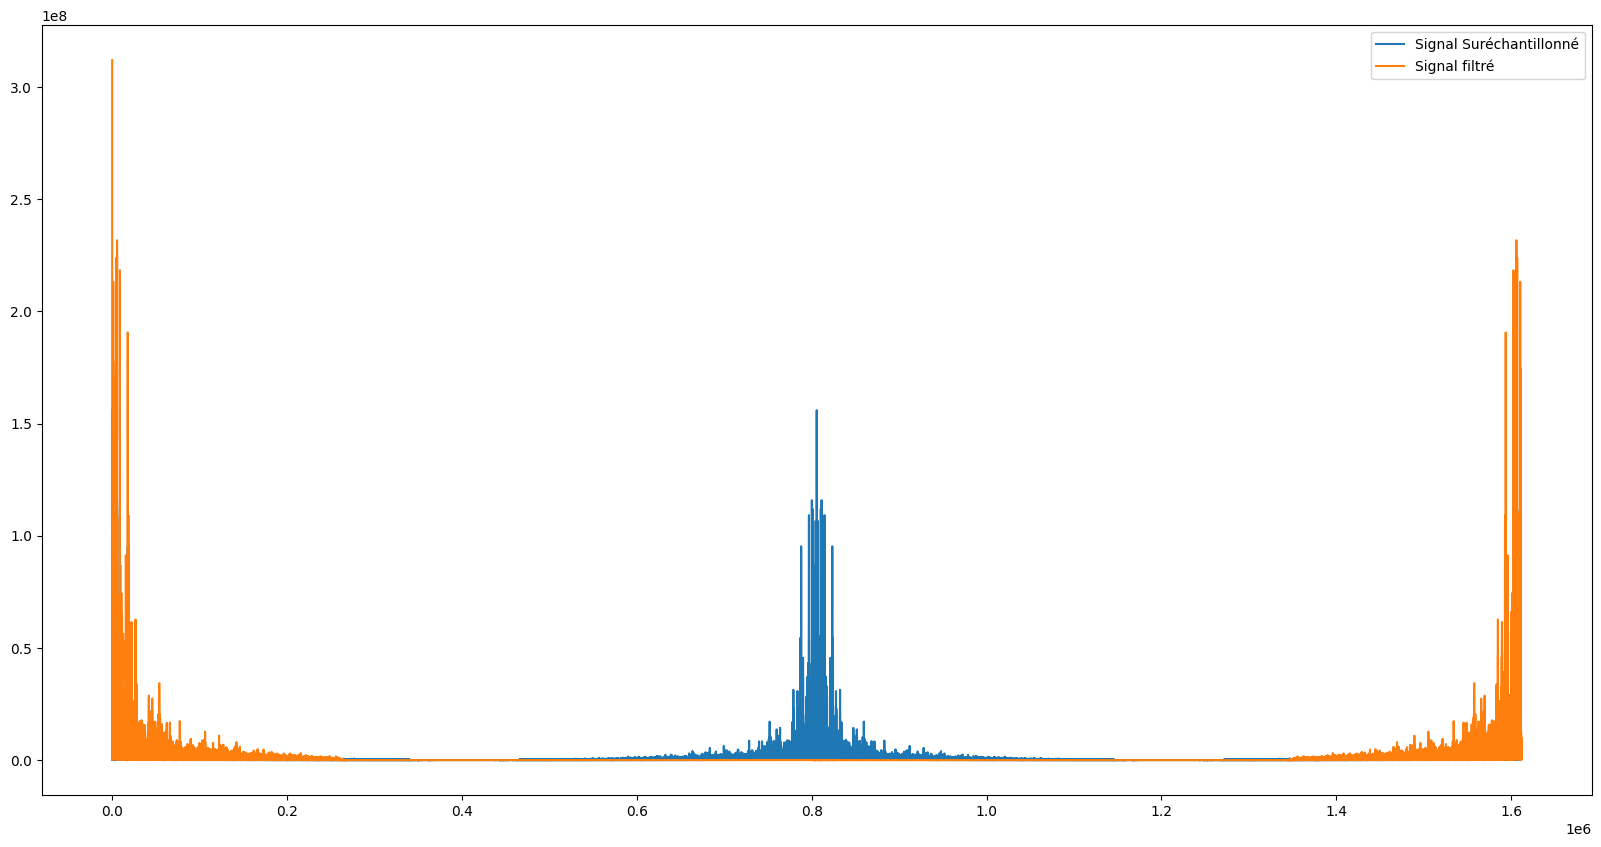

In [156]:
# Sur echantillonnage
x_sur = np.zeros(L*len(x))
x_sur[::L]=x

# Filtrage
%timeit scipy.signal.lfilter(taps,1,x_sur)
x_filt = scipy.signal.lfilter(taps,1,x_sur)

fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.plot(abs(np.fft.fft(x_sur)), label = "Signal Suréchantillonné")
ax.plot(abs(np.fft.fft(x_filt)), label ="Signal filtré")
ax.legend()
plt.show()

#Decimation
x_dec = x_filt[::M]

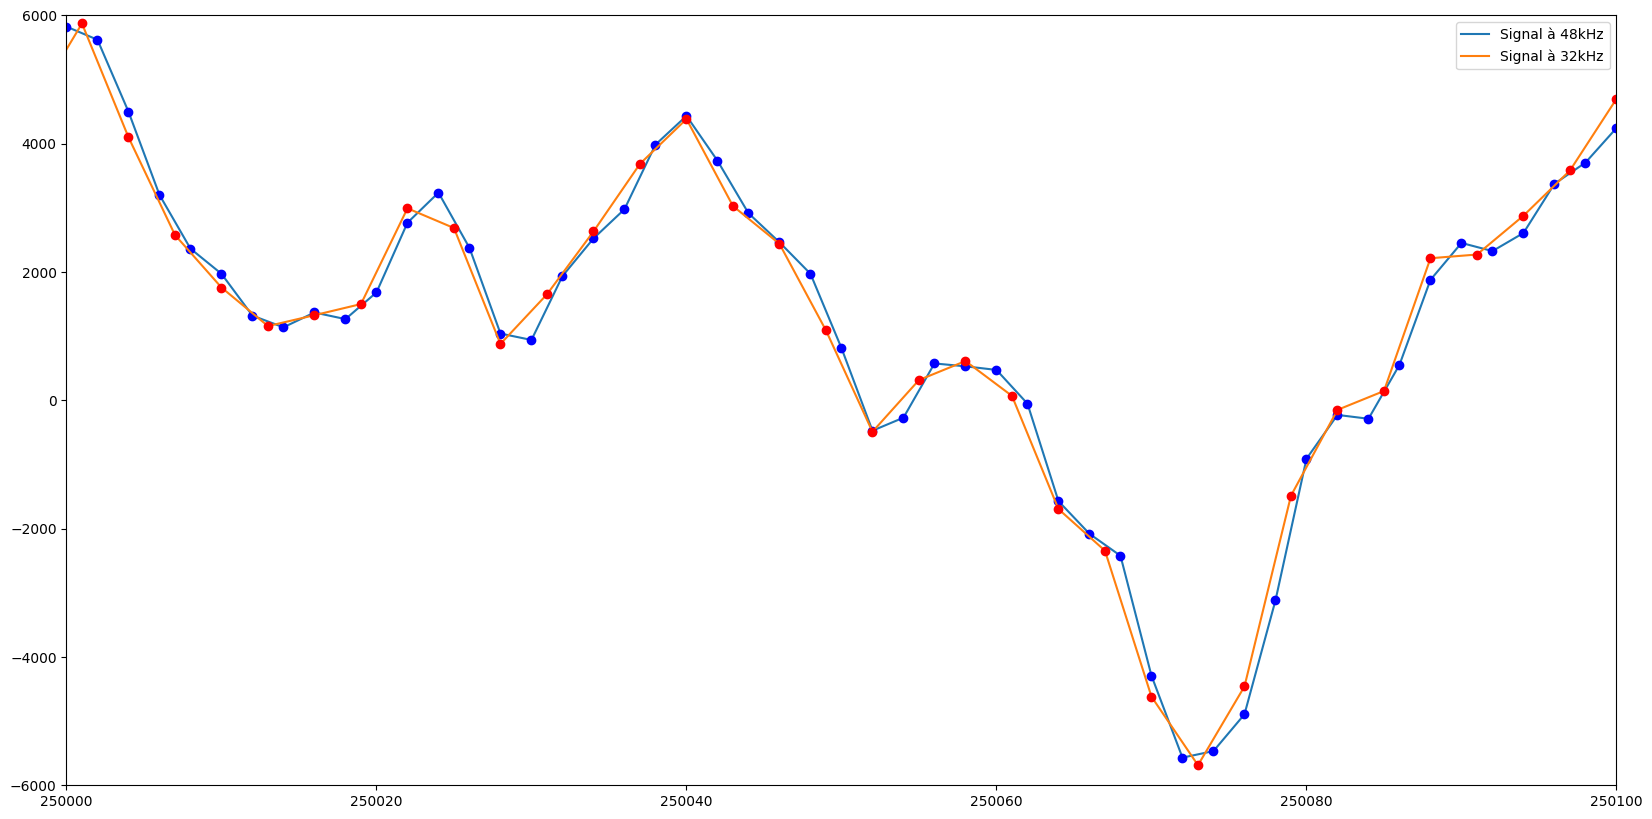

In [157]:

# Affichage des deux signaux

## Le signal filtré est retardé de la moitié de la longueur du filtre. Lors de l'affichage on décale donc ce signal pour observer les différences entre les signaux.
t = np.arange(L*len(x))
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.plot(t[::L], x, label = "Signal à 48kHz")
ax.plot(t[::L], x, 'ob')
ax.plot(t[::M] - numtaps/2, x_dec, label = "Signal à 32kHz")
ax.plot(t[::M] - numtaps/2, x_dec, 'or')
ax.set_ylim(-6000,6000)
t_0 = 250000
ax.set_xlim(t_0, t_0+100)
ax.legend()
plt.show()

On observe bien sur la figure ci-dessus que le signal ré-échantillonné correspond au signal de base échantillonné avec seulement $\frac{2}{3}$ des échantillons de base.

In [158]:
write('new_caravan.wav', int(Fs*L/M), np.array(x_dec, dtype=np.int16)) # to write a new wave file

Après écoute des deux fichiers, aucune différence n'est notable. La conversion de fréquence d'échantillonnage s'est bien déroulée.

Question 4 :

On cherche à montrer l'équivalence entre deux schémas de traitement. On utilise les identités Noble pour manipuler le schéma. Cette manipulation a pour but de filtrer à une fréquence d'échantillonnage faible afin de limiter le nombre de calculs.

<p align="center">
<img src="eq_schema.jpg">
</p>

La dernière modification est valable car 3 et 2 sont premiers entre eux.

Question 5 :

On peut montrer que les trois schémas ci-dessous sont équivalents. Le schéma encadré en rouge est celui d'un filtre polyphase. Les coefficients du filtre ont pour expression :

\begin{align*}
E_i &= H[i::L]\\
E_{ij} &= E_i[j::M]
\end{align*}

<p align="center">
<img src="polyphase.jpg">
</p>

In [159]:
## Implémentation du filtre polyphase
def polyphase(x, filtre, L, M):
    n = len(x)
    # Taille du signal décimé
    n_dec_M = n//M + 1*(n%M>0)
    result = np.zeros(L*(n_dec_M))
    for i in range(L):
        # Signal entrant dans les 2  premiers blocs

        # Retard de 1 echantillon, fait par rotation 
        # circulaire pour éviter les problémes de tailles de tableaux
        s_e = np.roll(x,-i)
        s_f = np.zeros(n_dec_M)
        # Premieres composantes polyphases du filtre 
        E_i = np.roll(filtre,-i)[::L]
        for j in range(M):
            # Signal sortant du decimateur dans chacun des 6 blocs
            s_dec = np.roll(s_e,-j)[::M]
            # Filtre E_i,j
            E_ij = np.roll(E_i, j)[::M]
            ###################
            # Filtrage par E_ki
            s_f += scipy.signal.lfilter(E_ij,1,s_dec)
            ###################
        result[i::L]=s_f
    return result
L = 2; M = 3
%timeit polyphase(x, taps, L, M)
x_poly = polyphase(x, taps, L, M)
write('new_caravan_polyphase.wav', int(Fs*L/M), np.array(x_poly, dtype=np.int16))

28.2 ms ± 664 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


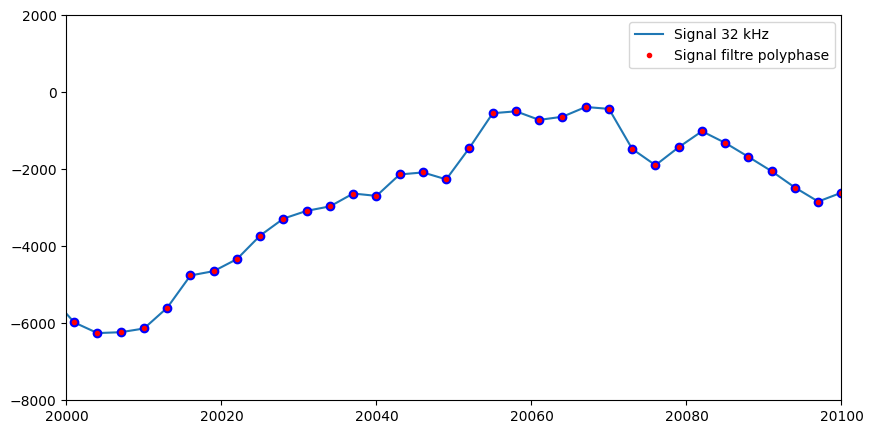

In [160]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
ax.plot(t[::M], x_dec, label = "Signal 32 kHz")
ax.plot(t[::M], x_dec, 'ob')
ax.plot(t[::M], x_poly, '.r', label = "Signal filtre polyphase")
ax.set_ylim(-8000,2000)
t_0 = 20000
ax.set_xlim(t_0, t_0+100)
ax.legend()
plt.show()

Le filtre polyphase est environ 2 fois plus rapide que le traitement non optimisé. Etant donné le nombre d'opérations Python, on ne peut pas juger ce gain de manière importante.

## Signal analysis with the STFT

In [161]:
N = x.shape[0] # % longueur du signal
Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
R = Nw//4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
Nt = round((N - Nw) / R)
M = 2*Nw # ordre de la tfd

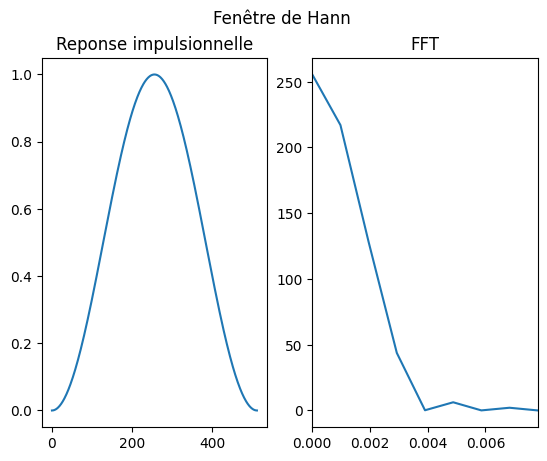

In [162]:
plt.subplot(121)
plt.suptitle("Fenêtre de Hann")
plt.plot(w)
plt.title("Reponse impulsionnelle")
plt.subplot(122)
plt.plot(np.arange(M)/M,abs(np.fft.fft(w,M)))
plt.xlim(0, 4/Nw)
plt.title("FFT")
plt.show()

La demi largeur du lobe principal vaut $\frac{2}{N_w}$ en fréquence normalisée.

Si on regarde la TFCT comme un produit de convolution, on observe qu'elle agit comme une suite de filtres passe bas, avec un décalage de la fenêtre à chaque pas. La réponse impulsionnelle du filtre est symétrique, donc il est de type 1 si la taille de la fenêtre est paire, de type 2 sinon.

Dans le code, on centre le signal par rapport à la fenêtre, donc on est convention passe-bande. La différence entre les deux se résume à une différence de phase.

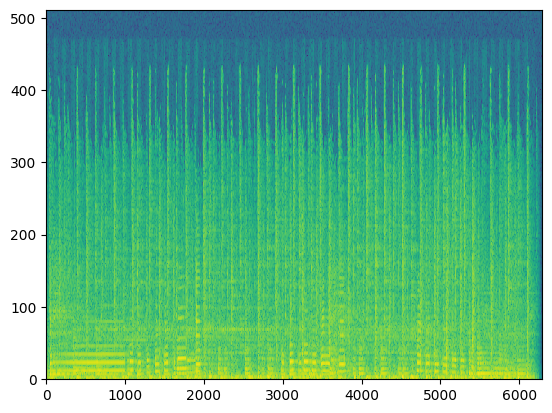

In [163]:
def stft(x, w, R, M):
    N = len(x); Nw = len(w)
    Nt = round((N - Nw) / R)
    out = np.zeros((M, Nt), dtype=np.complex_)
    for k in range(Nt):
        deb = k * R     
        fin = deb + Nw
        tx = x[deb : fin] * w
        out[:,k] = np.fft.fft(tx,M)
    return out
Xtilde=stft(x, w, R, M)
plt.imshow(20*np.log10(np.abs(Xtilde[:M//2,:])), aspect='auto',interpolation='none', origin='lower')
plt.show()

## Overlap-add reconstruction

### Condition de reconstruction parfaite 

On utilisera les notations suivantes : 
- $N_t$ : Nombre de fenêtres temporelles
- $R$ : Hop size
- $N$ : Taille des fenêtres
- $M$ : Taille de la FFT
- $w_a$ : Fenêtre de calcul de la STFT
- $w_s$ : Fenêtre de reconstruction
$$
y_w(n, u)=\frac{1}{N}\sum_{k=0}^{N-1}STFT(u,k)e^{2i\pi\frac{k}{M}(n)}
$$

On part de la définition du signal reconstruit pour trouver une condition sur les fenêtres.

\begin{align*}
y(n)&=\sum_{u=0}^{N_t-1}w_s(n - u*R)y_w(n-u*R, u)\\
&=\sum_{u=0}^{N_t-1}w_s(n - u*R)\frac{1}{N}\sum_{k=0}^{N-1}STFT(u,k)e^{2i\pi\frac{k}{M}(n-u*R)}\\
&=\sum_{u=0}^{N_t-1}w_s(n - u*R)\frac{1}{N}\sum_{k=0}^{N-1}  \sum_{m=0}^{N-1} w_a(m)x(m+u*R)    e^{2i\pi\frac{k}{M}(n-u*R-m)}\\
&=\sum_{u=0}^{N_t-1}w_s(n - u*R) \sum_{m=0}^{N-1} w_a(m)x(m+u*R)  \frac{1}{N}\sum_{k=0}^{N-1}  e^{2i\pi\frac{k}{M}(n-u*R-m)}\\
\end{align*}

Ici il faut remarquer que $\frac{1}{N}\sum_{k=0}^{N-1}  e^{2i\pi\frac{k}{M}(n-u*R-m)} = {\huge \bf1}_{n-m-u*R} $ qui vaut 1 quand $m=n-u*R$ et 0 sinon. On substitut donc dans l'équation précédente :

\begin{align*}
y(n)&=\sum_{u=0}^{N_t-1}w_s(n - u*R) \sum_{m=0}^{N-1} w_a(m)x(m+u*R)  {\huge \bf1}_{n-m-u*R}\\
&=\sum_{u=0}^{N_t-1}w_s(n - u*R) w_a(n-u*R)x(n)\\
&=x(n)\sum_{u=0}^{N_t-1}w_s(n - u*R) w_a(n-u*R)
\end{align*}

On retrouve bien la condition portant sur le Complete Overlap ADD :
$$
\sum_{u=0}^{N_t-1}w_s(n - u*R) w_a(n-u*R)=1
$$

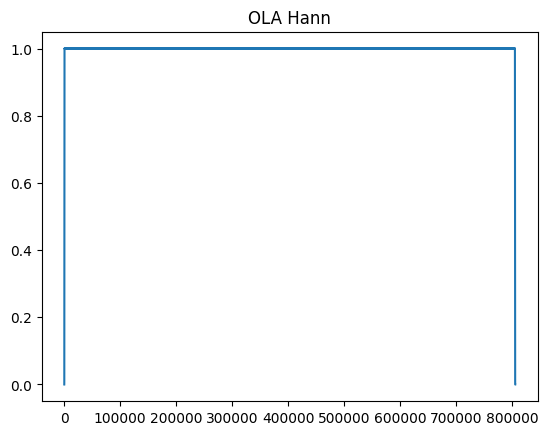

In [164]:
from matplotlib.pyplot import ylim
from scipy.fft import ifft


def ola(w = None,hop = None,Nb = 10): 
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    N = len(w)
    output = np.zeros(Nb * hop + N) # réserve l'espace memoire
    for k in range(0,Nb):
        deb = k * hop
        fin = deb + N
        output[deb:fin] = output[deb:fin] + w
    return output
ola_hann = ola(w**2, R, Nt)
corr = sum(ola_hann)/(Nt*R)
plt.plot(ola_hann/corr)
plt.title("OLA Hann")
plt.show()

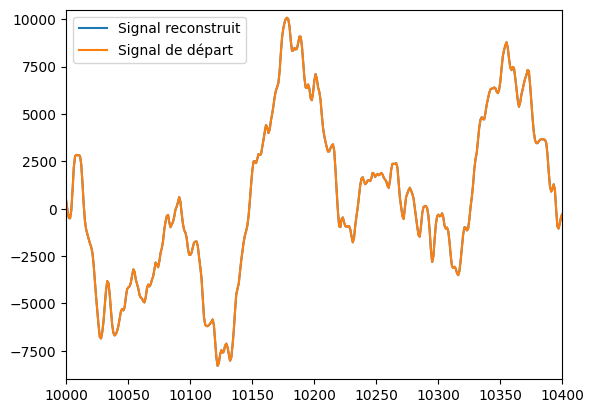

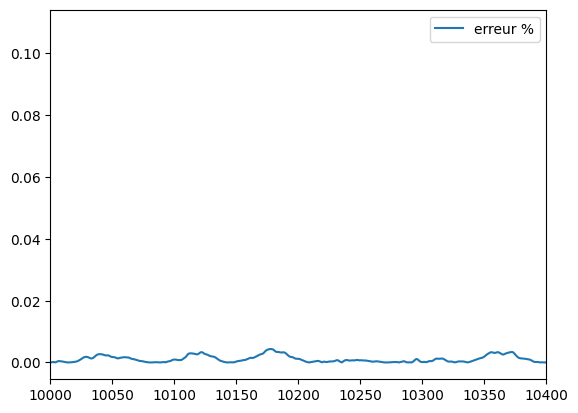

Moyenne de l'erreur : 0.001%


In [165]:
def reconstruction(stft, w, R, Nw):
    ## w is the window used for reconstruction
    #  R is the hop size
    #  M is the length of the fft
    M, Nt = stft.shape
    out = np.zeros(Nt * R + Nw)
    for k in range(Nt):
        deb = k*R
        fin = deb + Nw
        out[deb:fin] += w*np.fft.ifft(stft[:,k], M)[:Nw].real
    return out
ws = w/corr
y = reconstruction(Xtilde, ws, R, Nw)
if len(y)>len(x):
    error = 100*abs(y-np.concatenate((x,np.zeros(len(y)-len(x)))))/max(x)
else:
    error = 100*abs(y-x[:len(y)])/max(x)
plt.plot(y, label = "Signal reconstruit")
plt.plot(x, label = "Signal de départ")
plt.ylim(-9000, 10500)
plt.xlim(10000, 10400)
plt.legend()
plt.show()
plt.plot(error, label = "erreur %")
plt.xlim(10000, 10400)
plt.legend()
plt.show()
print(f"Moyenne de l'erreur : {error.mean():.3f}%")

## Egaliseur Audio

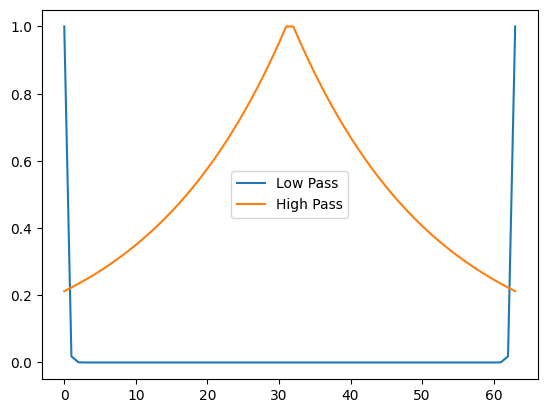

In [191]:
from cmath import exp


def egaliseur(stft, w, R, Nw, weights):
    M, Nt = stft.shape
    if len(weights)!=M:
        print(f"Erreur sur les poids : la FFT est de taille {M=} alors que les poids sont de taille {len(weights)=}")
        return 
    out = np.zeros(Nt * R + Nw)
    for k in range(Nt):
        deb = k*R
        fin = deb + Nw
        out[deb:fin] += w*np.fft.ifft(stft[:,k]*weights, M)[:Nw].real
    return out

N = x.shape[0]
Nw = 64
w = np.hanning(Nw)
R = Nw//4
Nt = round((N - Nw) / R)
M = Nw
corr = sum(ola(w*w,R,Nt))/(Nt*R)

exp_decay = np.exp(-4*np.arange(0,M//2))
weights_lp = np.concatenate((exp_decay, list(reversed(exp_decay))))
plt.plot(weights_lp, label = "Low Pass")

exp_decay = np.exp(-0.05*np.arange(0,M//2))
weights_hp = np.concatenate((list(reversed(exp_decay)), exp_decay))
plt.plot(weights_hp, label = "High Pass")
plt.legend()
plt.show()
Xtilde = stft(x, w, R, M)
signal_egal = egaliseur(Xtilde, w/corr, R, Nw, weights_lp)
write('caravan_egalise.wav', Fs, np.array(signal_egal, dtype=np.int16))